In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



In [23]:
# Load the NPZ file
data = np.load('0_5_60.npz')

# View available arrays
print(data.files)

# Access arrays by name
array1 = data['matrices']

# Or iterate through all arrays
for key in data.files:
    print(f"{key}: {data[key]}")

['coords', 'matrices']
coords: [[2.500e-01 2.500e-01 1.500e+00]
 [2.500e-01 7.500e-01 1.500e+00]
 [2.500e-01 1.250e+00 1.500e+00]
 ...
 [2.558e+02 2.548e+02 1.500e+00]
 [2.558e+02 2.552e+02 1.500e+00]
 [2.558e+02 2.558e+02 1.500e+00]]
matrices: [[[-3.782e-18+3.312e-18j  3.453e-18-3.652e-18j -3.095e-18+3.960e-18j
    2.709e-18-4.233e-18j]
  [ 4.819e-18+1.431e-18j -4.932e-18-9.708e-19j  5.001e-18+5.026e-19j
   -5.025e-18-3.006e-20j]
  [-1.362e-18-4.839e-18j  1.811e-18+4.689e-18j -2.245e-18-4.497e-18j
    2.658e-18+4.265e-18j]
  [-3.366e-18+3.734e-18j  2.998e-18-4.035e-18j -2.604e-18+4.299e-18j
    2.186e-18-4.525e-18j]]

 [[ 3.141e-18+3.954e-18j -3.504e-18-3.635e-18j  3.836e-18+3.283e-18j
   -4.132e-18-2.900e-18j]
  [ 1.642e-18-4.775e-18j -1.177e-18+4.910e-18j  7.009e-19-5.000e-18j
   -2.187e-19+5.043e-18j]
  [-4.908e-18+1.186e-18j  4.771e-18-1.652e-18j -4.590e-18+2.101e-18j
    4.367e-18-2.532e-18j]
  [ 3.641e-18+3.498e-18j -3.960e-18-3.132e-18j  4.243e-18+2.737e-18j
   -4.485e-18-2.316

In [84]:
print(len(array1))
data_arr = array1[:504]

262144


In [122]:
# divide data_arr by its average value for each entry
data_arr = data_arr / np.mean(np.abs(data_arr).flatten())


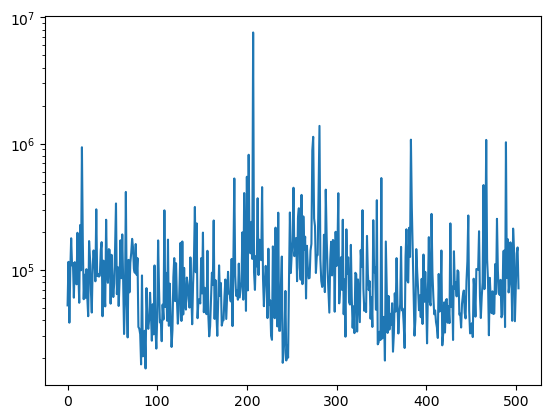

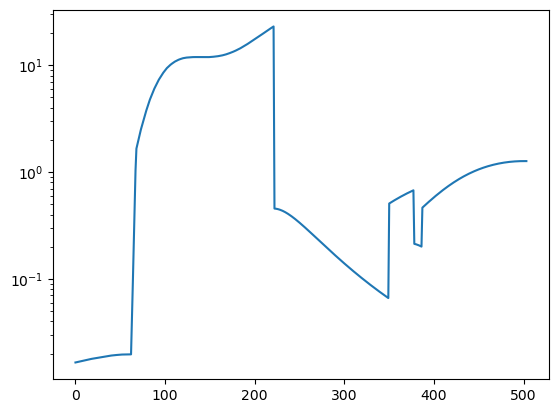

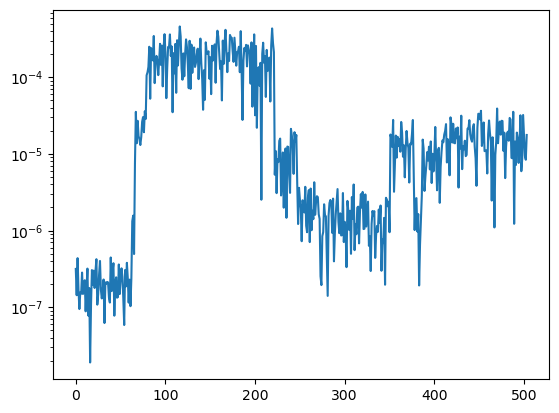

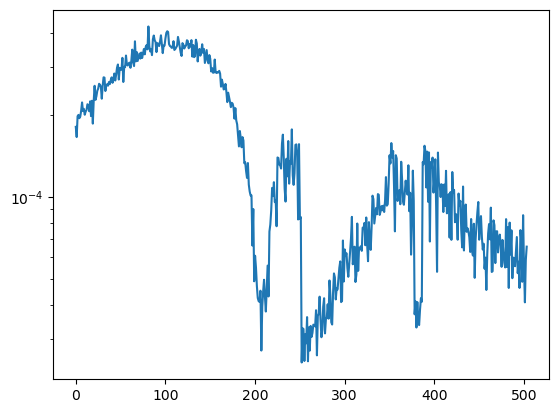

In [123]:

# Compute singular values for all matrices in array1
sv_arr = np.zeros((0, 4))
for i, matrix in enumerate(data_arr):
    if not np.isnan(matrix).any():
        U, s, Vt = np.linalg.svd(matrix)
        sv_arr = np.vstack([sv_arr, s])


plt.semilogy(sv_arr[:, 0]/ sv_arr[:, -1])

plt.show()
plt.semilogy(sv_arr[:, 0])

plt.show()
plt.semilogy(sv_arr[:, -1])

plt.show()
plt.semilogy(sv_arr[:, 1]/sv_arr[:, 0])


In [130]:
def clustering_alg(data: np.ndarray, n_clusters = 2):

    data_arr = data / np.mean(np.abs(data).flatten())

    # Determine number of clusters (for example, 1 cluster per 50 samples)
    

    sv_arr = np.zeros((0, 4))

    # Compute singular values for all matrices in data_arr
    for i, matrix in enumerate(data_arr):
        if not np.isnan(matrix).any():
            U, s, Vt = np.linalg.svd(matrix)
            sv_arr = np.vstack([sv_arr, s])

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(sv_arr**2)
    return kmeans.labels_, kmeans.cluster_centers_

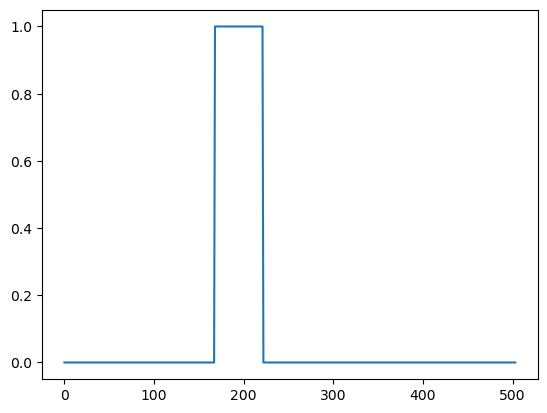

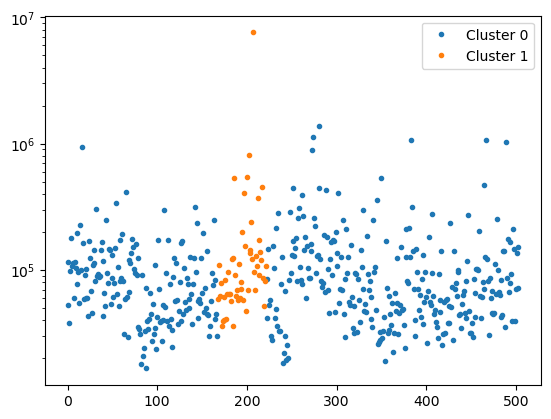

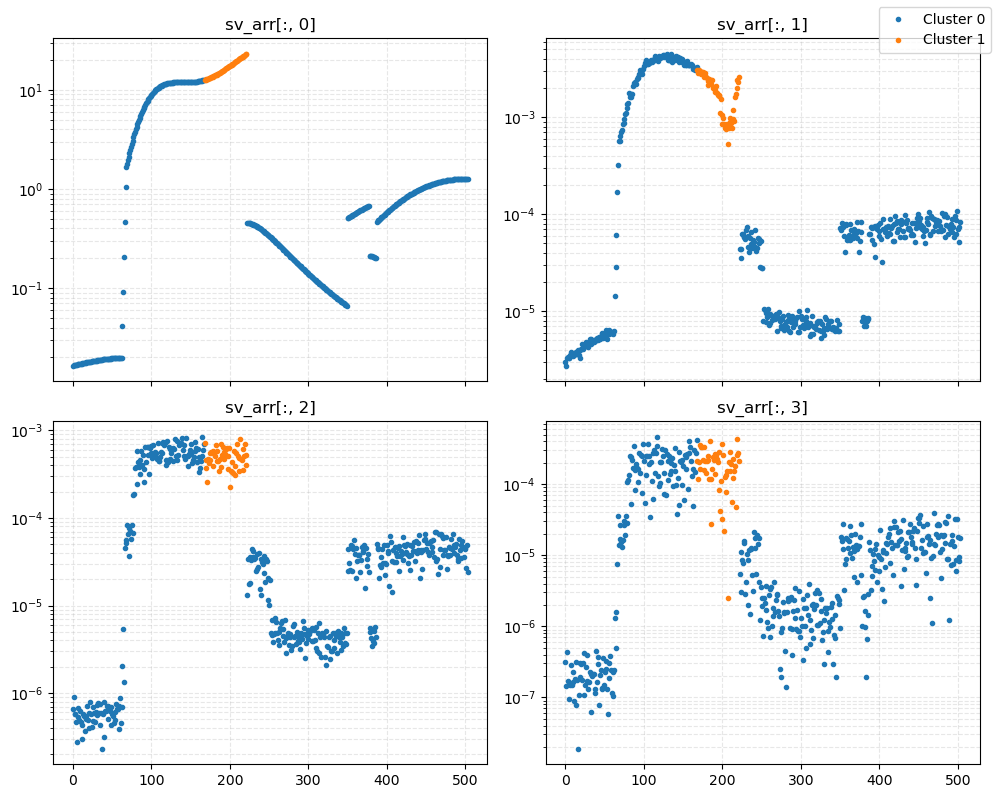

[]

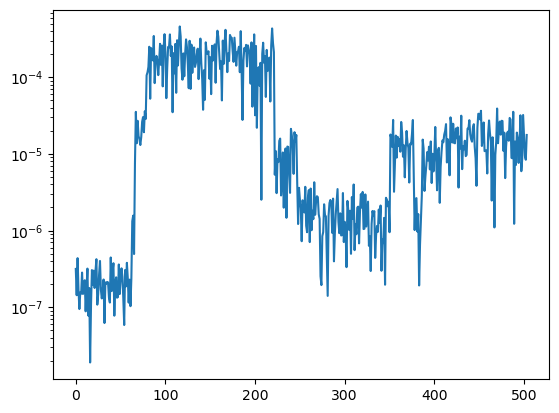

In [136]:
labels, centers = clustering_alg(data_arr, 2)

sv_arr = np.zeros((0, 4))

# Compute singular values for all matrices in data_arr
for i, matrix in enumerate(data_arr):
    if not np.isnan(matrix).any():
        U, s, Vt = np.linalg.svd(matrix)
        sv_arr = np.vstack([sv_arr, s])

plt.plot(labels)
plt.show()
for label in np.unique(labels):
    idx = labels == label
    plt.semilogy(np.where(idx)[0], (sv_arr[idx, 0] / sv_arr[idx, -1]), '.', label=f'Cluster {label}')
plt.legend()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()

for col in range(4):
    ax = axes[col]
    for label in np.unique(labels):
        idx = labels == label
        ax.semilogy(np.where(idx)[0], sv_arr[idx, col], '.', label=f'Cluster {label}')
    ax.set_title(f'sv_arr[:, {col}]')
    ax.grid(True, which='both', ls='--', alpha=0.3)

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right')
plt.tight_layout()
plt.show()
# plt.plot(centers.reshape(centers.shape[0], -1).T)
plt.semilogy(sv_arr[:, -1])
plt.plot()


In [137]:
def capacity_estimate(singular_values: np.ndarray, noise_variance: float) -> float:
    """Estimate the channel capacity given singular values and noise variance.

    Args:
        singular_values (np.ndarray): Array of singular values of the channel matrix.
        noise_variance (float): Variance of the noise.

    Returns:
        float: Estimated channel capacity.
    """
    capacity = 0.0
    for sv in singular_values:
        snr = (sv ** 2) / noise_variance
        capacity += np.log2(1 + snr)
    return capacity

In [138]:
def capacity_from_Hmatrix(H: np.ndarray, noise_variance: float) -> float:
    """Calculate channel capacity from channel matrix H.

    Args:
        H (np.ndarray): Channel matrix.
        noise_variance (float): Variance of the noise.

    Returns:
        float: Estimated channel capacity.
    """
    return np.log(np.linalg.det(np.eye(H.shape[0]) + (1 / noise_variance) * H @ H.conj().T)) / np.log(2)

In [146]:
capacity_arr = np.zeros(len(data_arr))
for i, matrix in enumerate(data_arr):
    if not np.isnan(matrix).any():
        cap = capacity_from_Hmatrix(data_arr[i], 1)
        capacity_arr[i] = cap


/var/folders/m4/118lpvmd05q63v2lh_ldv3xr0000gp/T/ipykernel_22568/504786800.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  capacity_arr[i] = cap


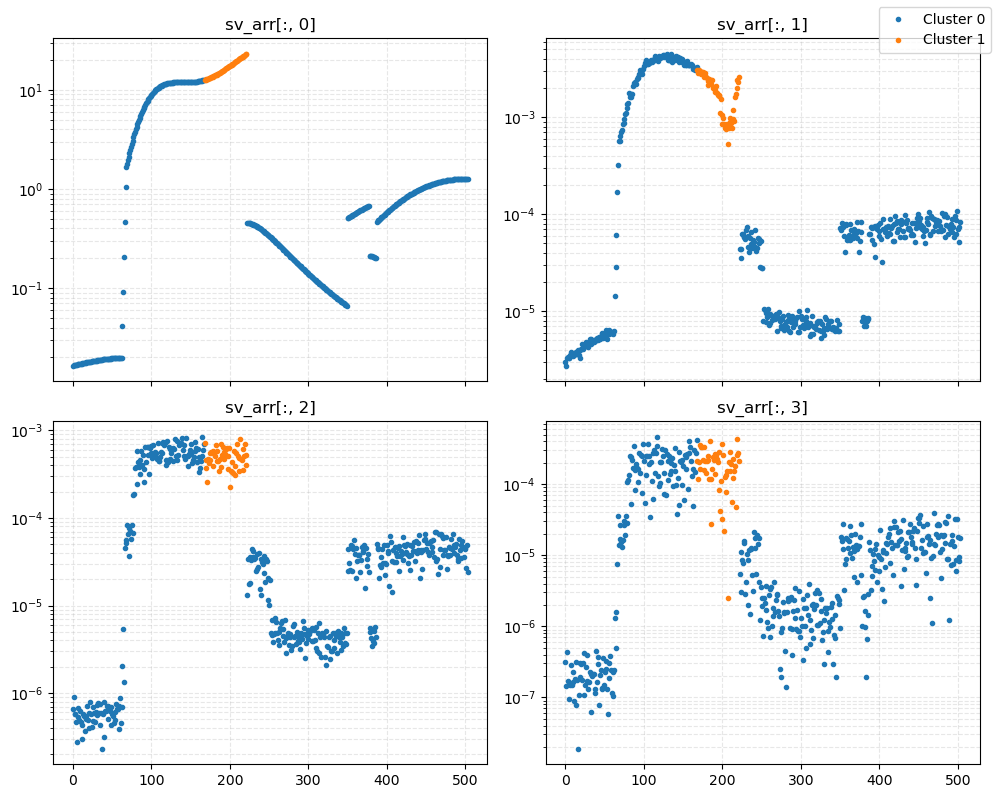

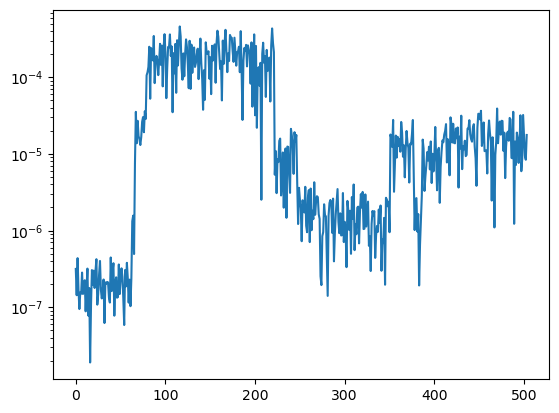

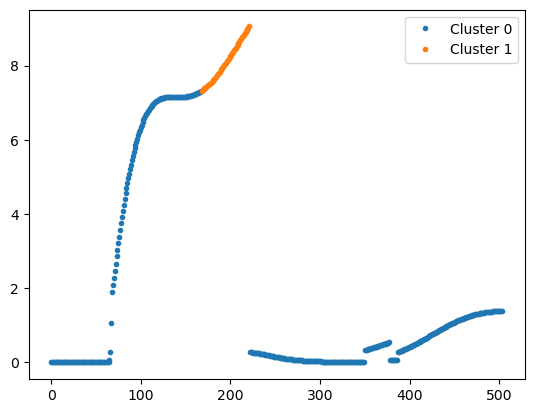

In [147]:
labels, centers = clustering_alg(data_arr, 2)

sv_arr = np.zeros((0, 4))

# Compute singular values for all matrices in data_arr
for i, matrix in enumerate(data_arr):
    if not np.isnan(matrix).any():
        U, s, Vt = np.linalg.svd(matrix)
        sv_arr = np.vstack([sv_arr, s])

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.ravel()

for col in range(4):
    ax = axes[col]
    for label in np.unique(labels):
        idx = labels == label
        ax.semilogy(np.where(idx)[0], sv_arr[idx, col], '.', label=f'Cluster {label}')
    ax.set_title(f'sv_arr[:, {col}]')
    ax.grid(True, which='both', ls='--', alpha=0.3)

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper right')
plt.tight_layout()
plt.show()
# plt.plot(centers.reshape(centers.shape[0], -1).T)
plt.semilogy(sv_arr[:, -1])
plt.plot()
plt.show()

for label in np.unique(labels):
    idx = labels == label
    plt.plot(np.where(idx)[0], (capacity_arr[idx]), '.', label=f'Cluster {label}')
plt.legend()
plt.show()
